In [1]:
# Jai Mata Di
# Project on DataScience
# Author : Aditya Upadhyay
# Date : 2024 - 10 - 29
# Proffessor Supratim Shit


In [ ]:
import pandas as pd
from scipy.stats import shapiro

# Load your dataset
data = pd.read_csv(r"archive (2)\city_hour.csv")

# Option 1: Impute missing values with the mean
# data['AQI'].fillna(data['AQI'].mean(), inplace=True)

# Option 2: Impute missing values with the median (uncomment if preferred)
data['AQI'].fillna(data['AQI'].median(), inplace=True)

# Perform Shapiro-Wilk test on the AQI column
stat, p_value = shapiro(data['AQI'])

# Print results
alpha = 0.05  # significance level
if p_value > alpha:
    print("AQI column appears to follow a normal distribution (fail to reject H0).")
else:
    print("AQI column does not follow a normal distribution (reject H0).")


AQI column does not follow a normal distribution (reject H0).


C:\Users\harsh\AppData\Local\Temp\ipykernel_17088\3802103883.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['AQI'].fillna(data['AQI'].median(), inplace=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_17088\3802103883.py:14: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 707875.
  stat, p_value = shapiro(data['AQI'])


In [3]:
import pandas as pd
from scipy.stats import f_oneway


# Group AQI data by city
cities = data['City'].unique()
aqi_groups = [data[data['City'] == city]['AQI'] for city in cities]

# Perform ANOVA
stat, p_value = f_oneway(*aqi_groups)

# Print results
alpha = 0.05  # significance level
if p_value > alpha:
    print("No significant difference in AQI among cities (fail to reject H0).")
else:
    print("Significant difference in AQI among cities (reject H0).")


Significant difference in AQI among cities (reject H0).


In [4]:
from scipy.stats import zscore, f_oneway
import pandas as pd


# Fill null values with the median only for numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns
data[numerical_cols] = data[numerical_cols].apply(lambda x: x.fillna(x.median()))

# Select only the dependent columns (PM2.5, NO, NO2, CO, AQI) for analysis
data_dependent = data[['PM2.5', 'NO', 'NO2', 'CO', 'AQI']]

# Normalize each column using z-score normalization
data_normalized = data_dependent.apply(zscore)

# Organize each normalized column as a separate group for ANOVA
groups = [data_normalized[col] for col in data_normalized.columns]

# Perform ANOVA test on the dependent columns
stat, p_value = f_oneway(*groups)

# Print results
alpha = 0.05  # significance level
if p_value > alpha:
    print("No significant difference in means among normalized PM2.5, NO, NO2, CO, and AQI (fail to reject H0).")
else:
    print("Significant difference in means among normalized PM2.5, NO, NO2, CO, and AQI (reject H0).")

# Display p-value for further analysis
print(f"ANOVA test p-value: {p_value}")


No significant difference in means among normalized PM2.5, NO, NO2, CO, and AQI (fail to reject H0).
ANOVA test p-value: 1.0


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, chi2

# Load the dataset
# data = pd.read_csv('your_dataset.csv')  # Uncomment and specify your dataset path

# Select only columns with chemical attributes
chemical_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

# Impute missing values with the median for each chemical attribute column
data[chemical_columns] = data[chemical_columns].apply(lambda x: x.fillna(x.median()), axis=0)

# Bin each chemical attribute into 4 categories
for col in chemical_columns:
    data[col] = pd.qcut(data[col], q=4, labels=False, duplicates='drop')

# Degrees of freedom for a 4x4 contingency table
df = (4 - 1) * (4 - 1)

# Bonferroni correction for multiple comparisons
alpha = 0.05
num_comparisons = len(chemical_columns) * (len(chemical_columns) - 1) / 2
adjusted_alpha = alpha / num_comparisons
adjusted_critical_value = chi2.ppf(1 - adjusted_alpha, df)

# Print adjusted critical value and hypotheses
print(f"Adjusted Critical Value for Chi-square test (df={df}, adjusted alpha={adjusted_alpha:.5f}): {adjusted_critical_value:.2f}")
print("Null Hypothesis (H0): There is no association between the two categorical variables.")
print("Alternative Hypothesis (H1): There is an association between the two categorical variables.")
print("\nInterpretation: If the test statistic is greater than the adjusted critical value, we reject the null hypothesis (indicating a significant association).\n")

# Initialize a DataFrame to store Chi-square test statistics for each chemical pair
chi_square_matrix = pd.DataFrame(index=chemical_columns, columns=chemical_columns)
dependent_pairs = []

# Calculate Chi-square statistic for each pair
for i, col1 in enumerate(chemical_columns):
    for j, col2 in enumerate(chemical_columns):
        if i == j:
            chi_square_matrix.loc[col1, col2] = np.nan  # Diagonal set to NaN
        elif j > i:  # Check each pair only once
            # Create a contingency table
            contingency_table = pd.crosstab(data[col1], data[col2])

            # Perform the Chi-square test
            chi2_stat, _, _, _ = chi2_contingency(contingency_table)

            # Store the Chi-square statistic in the matrix
            chi_square_matrix.loc[col1, col2] = f"{chi2_stat:.2f}"
            chi_square_matrix.loc[col2, col1] = f"{chi2_stat:.2f}"  # Fill symmetric cell

            # Check if the test statistic indicates dependency with adjusted critical value
            if chi2_stat > adjusted_critical_value:
                dependent_pairs.append((col1, col2))

# Display the Chi-square statistics matrix
print("\nChi-square Test Statistic Matrix:")
print(chi_square_matrix)

# Print pairs of dependent variables
print("\nDependent Variable Pairs (where H0 is rejected after Bonferroni correction):")
for pair in dependent_pairs:
    print(f"{pair[0]} and {pair[1]}")

print(len(dependent_pairs))

Adjusted Critical Value for Chi-square test (df=9, adjusted alpha=0.00076): 28.60
Null Hypothesis (H0): There is no association between the two categorical variables.
Alternative Hypothesis (H1): There is an association between the two categorical variables.

Interpretation: If the test statistic is greater than the adjusted critical value, we reject the null hypothesis (indicating a significant association).


Chi-square Test Statistic Matrix:
             PM2.5       PM10         NO        NO2        NOx        NH3  \
PM2.5          NaN  380263.96  145051.12  187376.34  128767.35   99617.03   
PM10     380263.96        NaN  137511.34  157513.59  126663.29  225519.83   
NO       145051.12  137511.34        NaN  211100.66  437468.83  104718.82   
NO2      187376.34  157513.59  211100.66        NaN  352460.42  154606.37   
NOx      128767.35  126663.29  437468.83  352460.42        NaN   62653.34   
NH3       99617.03  225519.83  104718.82  154606.37   62653.34        NaN   
CO       101

In [6]:
import pandas as pd

# Load your dataset


# Get unique values in the 'AQI_Bucket' column
unique_aqi_buckets = data['AQI_Bucket'].unique()

# Print unique AQI bucket values
print("Unique values in 'AQI_Bucket':", unique_aqi_buckets)


Unique values in 'AQI_Bucket': [nan 'Poor' 'Moderate' 'Very Poor' 'Severe' 'Satisfactory' 'Good']


In [7]:
import pandas as pd
from scipy.stats import chisquare


data['AQI_Bucket'] = data['AQI_Bucket'].fillna(data['AQI_Bucket'].mode()[0])

# Count the occurrences of each category in 'AQI Bucket'
observed_counts = data['AQI_Bucket'].value_counts()

# Define expected counts (for a uniform distribution, you can set them equal)
total_counts = observed_counts.sum()
num_categories = len(observed_counts)
expected_counts = [total_counts / num_categories] * num_categories  # Uniform expectation

# Perform Chi-square goodness-of-fit test
chi_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)

# Print the results
print(f"Chi-square Statistic: {chi_stat:.2f}, p-value: {p_value:.4f}")
print("Observed Counts:")
print(observed_counts)
print("Expected Counts:")
e=[int(i) for i in expected_counts]
print(e)

# Conclusion based on p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in proportions among the categories.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in proportions among the categories.")

Chi-square Statistic: 593329.19, p-value: 0.0000
Observed Counts:
AQI_Bucket
Moderate        328071
Satisfactory    189434
Poor             66654
Very Poor        57455
Good             38611
Severe           27650
Name: count, dtype: int64
Expected Counts:
[117979, 117979, 117979, 117979, 117979, 117979]
Reject the null hypothesis: There is a significant difference in proportions among the categories.


Loading and preparing data...
Filled NaNs in PM2.5 with median: 46.50
Filled NaNs in PM10 with median: 92.00
Filled NaNs in NO with median: 7.97
Filled NaNs in NO2 with median: 20.68
Filled NaNs in NOx with median: 20.99
Filled NaNs in NH3 with median: 15.87
Filled NaNs in CO with median: 0.84
Filled NaNs in SO2 with median: 8.46
Filled NaNs in O3 with median: 26.64
Filled NaNs in Benzene with median: 1.09
Filled NaNs in Toluene with median: 3.14
Filled NaNs in Xylene with median: 1.20

Available cities: ['Delhi' 'Ahmedabad' 'Bengaluru' 'Lucknow' 'Chennai' 'Hyderabad' 'Patna'
 'Gurugram' 'Visakhapatnam' 'Amritsar' 'Jorapokhar' 'Jaipur'
 'Thiruvananthapuram' 'Amaravati' 'Brajrajnagar' 'Talcher' 'Kolkata'
 'Mumbai' 'Guwahati' 'Coimbatore' 'Shillong' 'Chandigarh' 'Bhopal' 'Kochi'
 'Ernakulam' 'Aizawl']

Analyzing data for Delhi

Training Random Forest model for Delhi...


C:\Users\harsh\AppData\Local\Temp\ipykernel_17088\2663951025.py:89: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + timedelta(hours=1), periods=240, freq='H')  # 10 days * 24 hours


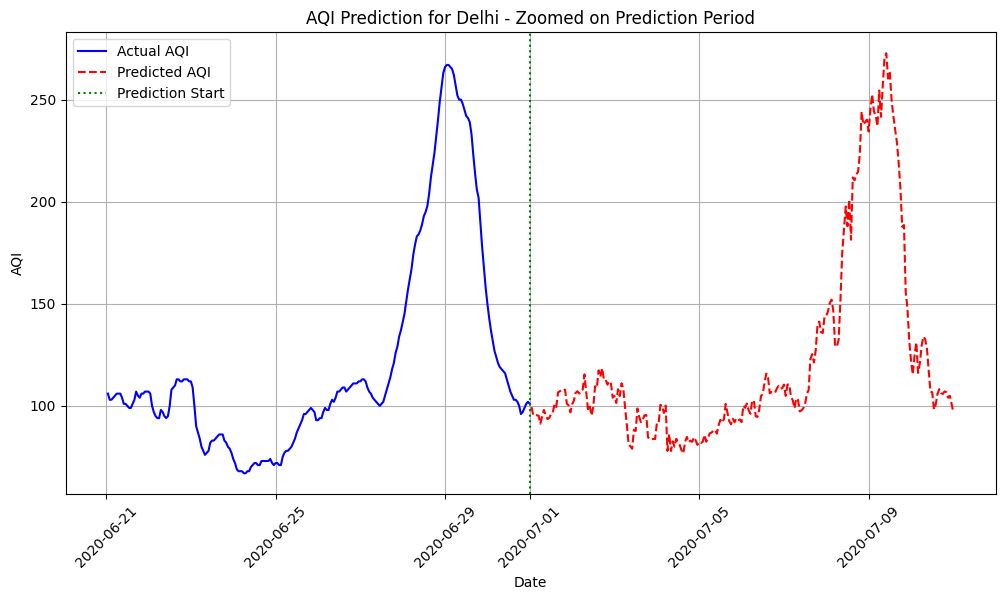


Model Performance Metrics:
R-squared Score: 0.977
Root Mean Square Error: 17.528
Mean Absolute Error: 11.600

Top 10 Most Important Features:
   feature  importance
0    PCA_1    0.561688
5    PCA_6    0.148252
10  PCA_11    0.147228
3    PCA_4    0.057158
2    PCA_3    0.017908
6    PCA_7    0.014452
1    PCA_2    0.010144
13   month    0.008538
8    PCA_9    0.007693
4    PCA_5    0.006670


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load and prepare the data
print("Loading and preparing data...")
data = pd.read_csv(r"C:\Users\harsh\Documents\GitHub\DSC_FINAL_PROJECT_ADI\archive (2)\city_hour.csv")

# Drop AQI_Bucket column
data = data.drop('AQI_Bucket', axis=1)

# Convert datetime
data['datetime'] = pd.to_datetime(data['Datetime'])
data = data.sort_values('datetime')

# Drop rows with NaN values in AQI, as we're treating this as a time series model
data = data.dropna(subset=['AQI'])

# Fill NaN values in other columns with the median
for col in data.columns:
    if data[col].isnull().sum() > 0:
        median_value = data[col].median()
        data[col] = data[col].fillna(median_value)
        print(f"Filled NaNs in {col} with median: {median_value:.2f}")

# Select features for PCA
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Apply PCA
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance
pca_features = pca.fit_transform(scaled_features)

# Create features for time series prediction
def create_time_features(df):
    df = df.copy()
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['day_of_week'] = df['datetime'].dt.dayofweek
    return df

# Get list of all cities
cities = data['City'].unique()
print("\nAvailable cities:", cities)

# Select a specific city (e.g., Delhi)
selected_city = 'Delhi'
print(f"\nAnalyzing data for {selected_city}")
city_data = data[data['City'] == selected_city].copy()
city_data = create_time_features(city_data)

# Combine PCA features with time features
pca_df = pd.DataFrame(
    pca_features[data['City'] == selected_city],
    columns=[f'PCA_{i+1}' for i in range(pca_features.shape[1])]
)
city_data = pd.concat([city_data.reset_index(drop=True), pca_df], axis=1)

# Prepare features for modeling
model_features = [f'PCA_{i+1}' for i in range(pca_features.shape[1])] + ['hour', 'day', 'month', 'year', 'day_of_week']
X = city_data[model_features]
y = city_data['AQI']

# Time-based train-test split (e.g., last 20% of the data for testing)
split_point = int(len(city_data) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Train the model
print(f"\nTraining Random Forest model for {selected_city}...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Create future dates for prediction
last_date = city_data['datetime'].max()
future_dates = pd.date_range(start=last_date + timedelta(hours=1), periods=240, freq='H')  # 10 days * 24 hours
future_data = pd.DataFrame({'datetime': future_dates})
future_data = create_time_features(future_data)

# Use the last known PCA features for future predictions (as a proxy for unseen data)
latest_pca = pca_df.iloc[-240:].values
future_pca = pd.DataFrame(
    latest_pca,
    columns=[f'PCA_{i+1}' for i in range(pca_features.shape[1])]
)
future_data = pd.concat([future_data, future_pca.reset_index(drop=True)], axis=1)

# Make future predictions
future_predictions = rf_model.predict(future_data[model_features])

# Create visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Actual and Predicted AQI with zoomed-in range
ax.plot(city_data['datetime'].iloc[-240:], city_data['AQI'].iloc[-240:], 
        label='Actual AQI', color='blue')
ax.plot(future_dates, future_predictions, 
        label='Predicted AQI', linestyle='--', color='red')
ax.axvline(x=last_date, color='green', linestyle=':', label='Prediction Start')
ax.set_title(f'AQI Prediction for {selected_city} - Zoomed on Prediction Period')
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
ax.legend()
ax.grid(True)
ax.tick_params(axis='x', rotation=45)

plt.show()

# Print model performance metrics
print("\nModel Performance Metrics:")
print(f"R-squared Score: {r2_score(y_test, y_pred):.3f}")
print(f"Root Mean Square Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.3f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': model_features,
    'importance': rf_model.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


In [23]:
# Extract the actual AQI values for the last 10 days
actual_aqi_last_10_days = city_data['AQI'].iloc[-240:]

# Extract the predicted AQI values for the 10-day forecast period
predicted_aqi_last_10_days = future_predictions[:240]

# Print actual and predicted AQI values for each day
print("Date        | Actual AQI | Predicted AQI")
print("------------|------------|--------------")
for date, actual, predicted in zip(future_dates, actual_aqi_last_10_days, predicted_aqi_last_10_days):
    print(f"{date.strftime('%Y-%m-%d %H:%M')} | {actual:.2f}      | {predicted:.2f}")


Date        | Actual AQI | Predicted AQI
------------|------------|--------------
2020-07-01 01:00 | 106.00      | 99.41
2020-07-01 02:00 | 103.00      | 95.39
2020-07-01 03:00 | 103.00      | 95.57
2020-07-01 04:00 | 104.00      | 95.37
2020-07-01 05:00 | 105.00      | 95.26
2020-07-01 06:00 | 106.00      | 91.27
2020-07-01 07:00 | 106.00      | 94.77
2020-07-01 08:00 | 106.00      | 98.03
2020-07-01 09:00 | 104.00      | 95.46
2020-07-01 10:00 | 101.00      | 93.54
2020-07-01 11:00 | 101.00      | 94.04
2020-07-01 12:00 | 100.00      | 95.89
2020-07-01 13:00 | 99.00      | 96.62
2020-07-01 14:00 | 99.00      | 100.79
2020-07-01 15:00 | 101.00      | 99.42
2020-07-01 16:00 | 103.00      | 106.57
2020-07-01 17:00 | 107.00      | 107.19
2020-07-01 18:00 | 105.00      | 107.79
2020-07-01 19:00 | 104.00      | 107.48
2020-07-01 20:00 | 106.00      | 107.98
2020-07-01 21:00 | 106.00      | 101.13
2020-07-01 22:00 | 107.00      | 100.22
2020-07-01 23:00 | 107.00      | 96.82
2020-07-02 00:0